In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Mounted at /content/drive


In [ ]:
# modelo
m = 1
# tamanho da janela deslizante
n = 3
veremiPath = "/content/drive/MyDrive/dataset/veremi"
t2Path = "/veremiWithT2"
simcsvPath = '/simulationscsv'
window = "/window"+str(n)+"v2"
model = "/model"+str(m)
lstmPath = '/lstm'
lstmunits = 32

os.chdir(veremiPath+t2Path+window+model+'/allscenarios2')
multi = pd.read_csv('allsc2.csv', index_col=0)
os.chdir(veremiPath+t2Path+window+model+'/allscenarios1')
binary = pd.read_csv('allsc1.csv', index_col=0)

# os.chdir(veremiPath+t2Path+window+lstmPath+model)
# os.listdir()

In [ ]:
# All scenarios 1
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
# split data and label
data = binary.iloc[:, 0:-1].values
classes = binary.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], int(data_train.shape[1]/2), 2)
data_test=data_test.reshape(data_test.shape[0], int(data_test.shape[1]/2), 2)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)
clTrain = lb.inverse_transform(classes_train)
clTest = lb.inverse_transform(classes_test)
# classes_train
clTrain = pd.Series(clTrain)
qtd0 = len(clTrain.loc[clTrain == 0])
qtd1 = len(clTrain.loc[clTrain == 1])
print('classes_train binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')
# classes_test
clTest = pd.Series(clTest)
qtd0 = len(clTest.loc[clTest == 0])
qtd1 = len(clTest.loc[clTest == 1])
print('classes_test binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')

data_train (14817733, 3, 2)
data_test (3704434, 3, 2)
classes_train (14817733, 2)
classes_test (3704434, 2)
classes_train binary distribution:
qtd 0 =  11908209 | 80.36458073579811 %
qtd 1 =  2909524 | 19.635419264201886 %
classes_test binary distribution:
qtd 0 =  2977507 | 80.37684029463071 %
qtd 1 =  726927 | 19.623159705369297 %


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modellstm = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'lstm')
print(modellstm.summary())
modellstm.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modellstm.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modellstm.save(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')

Model: "model1lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 450s 30ms/step - loss: 0.3791 - binary_accuracy: 0.8551 - recall: 0.2933
Epoch 2/200
14818/14818 [======================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/allscenarios1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/allscenarios1/assets


Best Threshold=0.202772, F-Score=0.614
----------------------------------------------------------------------
Classification Report for md1lstmbinary
              precision    recall  f1-score   support

     class 0      0.899     0.929     0.914   2977507
     class 1      0.663     0.572     0.614    726927

    accuracy                          0.859   3704434
   macro avg      0.781     0.751     0.764   3704434
weighted avg      0.853     0.859     0.855   3704434

----------------------------------------------------------------------


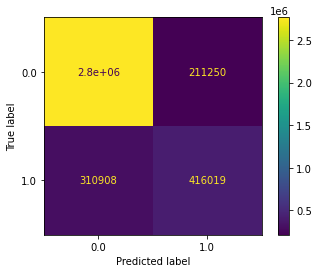

----------------------------------------------------------------------


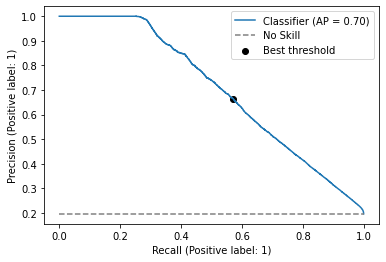

----------------------------------------------------------------------


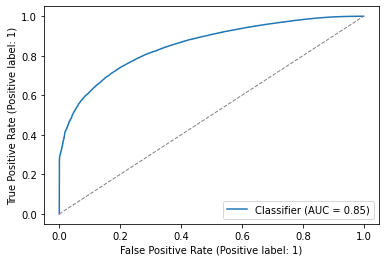

In [ ]:
# All scenarios - model allsc1
# metrics
from sklearn.preprocessing import MultiLabelBinarizer
os.chdir(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')
modellstm = keras.models.load_model(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')
proba = modellstm.predict(data_test)
clTest = lb.inverse_transform(classes_test)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, proba[:, 1], pos_label=1)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
pred = np.where(np.array(proba[:, 1]) >= thresholds[ix], 1, 0)
print('Classification Report for md'+str(m)+'lstm'+'binary')
print(classification_report(clTest, pred, target_names=['class 0', 'class 1'], digits=3))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'binary'+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, proba[:, 1], pos_label=1)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'lstm'+'binary'+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, proba[:, 1], pos_label=1)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'lstm'+'binary'+'.pdf')
plt.show()

In [ ]:
# All scenarios 2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
# multi.iloc[:, -1].unique()
# split data and label
data = multi.iloc[:, 0:-1].values
classes = multi.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], int(data_train.shape[1]/2), 2)
data_test=data_test.reshape(data_test.shape[0], int(data_test.shape[1]/2), 2)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)

data_train (14817733, 3, 2)
data_test (3704434, 3, 2)
classes_train (14817733, 6)
classes_test (3704434, 6)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modelmulti = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'multiclass')
print(modelmulti.summary())
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)
modelmulti.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.FalseNegatives()],
)
# all scenarios 2
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modelmulti.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
modellstm.save(veremiPath+t2Path+window+lstmPath+model+'/allscenarios2')

Model: "model1multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 3, 32)             4480      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 12,998
Trainable params: 12,998
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 408s 27ms/step - loss: 0.5147 - accuracy: 0.0000e+00 - false_negatives: 2239507.0000
Epoch 2/200
14818/14818 [====

INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/allscenarios2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/dataset/veremi/veremiWithT2/window3v2/lstm/model1/allscenarios2/assets


Classification Report for md1lstmmulti
              precision    recall  f1-score   support

     class 0      0.870     0.982     0.923   2977507
     class 1      0.742     0.592     0.659    144452
     class 2      0.000     0.000     0.000    143395
     class 4      0.997     0.992     0.994    145650
     class 8      0.570     0.198     0.293    145158
    class 16      0.457     0.107     0.174    148272

    accuracy                          0.863   3704434
   macro avg      0.606     0.478     0.507   3704434
weighted avg      0.808     0.863     0.825   3704434

----------------------------------------------------------------------


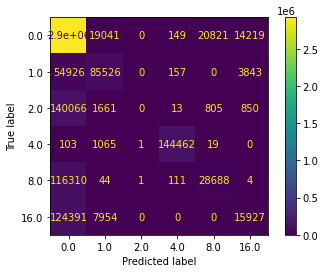

In [ ]:
# All scenarios - model allsc2
# metrics
os.chdir(veremiPath+t2Path+window+lstmPath+model+'/allscenarios2')
# Classification Report
from sklearn.metrics import classification_report
clTest = lb.inverse_transform(classes_test)
proba = modelmulti.predict(data_test)
pred = lb.inverse_transform(proba)
classlist = []
for cl in lb.classes_:
  classlist.append('class '+str(int(cl)))
print('Classification Report for md'+str(m)+'lstm'+'multi')
print(classification_report(clTest,
                            pred,
                            target_names=classlist,
                            digits=3,
                            zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'multi'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'multi'+'.pdf')
plt.show()

In [ ]:
# ONLY DIST, WITHOUT RSSI
# All scenarios 1
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
# retirar o RSSI
binonlydist = binary[['0', '2', '4', '6']]
# split data and label
data = binonlydist.iloc[:, 0:-1].values
classes = binonlydist.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
classes = MultiLabelBinarizer().fit_transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], data_train.shape[1], 1)
data_test=data_test.reshape(data_test.shape[0], data_train.shape[1], 1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)
clTrain = lb.inverse_transform(classes_train)
clTest = lb.inverse_transform(classes_test)
# classes_train
clTrain = pd.Series(clTrain)
qtd0 = len(clTrain.loc[clTrain == 0])
qtd1 = len(clTrain.loc[clTrain == 1])
print('classes_train binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')
# classes_test
clTest = pd.Series(clTest)
qtd0 = len(clTest.loc[clTest == 0])
qtd1 = len(clTest.loc[clTest == 1])
print('classes_test binary distribution:')
print('qtd 0 = ', qtd0, '|', qtd0*100/(qtd0+qtd1), '%')
print('qtd 1 = ', qtd1, '|', qtd1*100/(qtd0+qtd1), '%')

data_train (14817733, 3, 1)
data_test (3704434, 3, 1)
classes_train (14817733, 2)
classes_test (3704434, 2)
classes_train binary distribution:
qtd 0 =  11908209 | 80.36458073579811 %
qtd 1 =  2909524 | 19.635419264201886 %
classes_test binary distribution:
qtd 0 =  2977507 | 80.37684029463071 %
qtd 1 =  726927 | 19.623159705369297 %


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modellstm = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'lstm')
print(modellstm.summary())
modellstm.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.Recall(class_id=1)],
)
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modellstm.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
# modellstm.save(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')

Model: "model1lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 32)             4352      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 414s 27ms/step - loss: 0.3792 - binary_accuracy: 0.8552 - recall_1: 0.2900
Epoch 2/200
14818/14818 [====================

Best Threshold=0.132404, F-Score=0.590
----------------------------------------------------------------------
Classification Report for md1lstmbinary
              precision    recall  f1-score   support

     class 0      0.897     0.908     0.903   2977507
     class 1      0.605     0.575     0.590    726927

    accuracy                          0.843   3704434
   macro avg      0.751     0.742     0.746   3704434
weighted avg      0.840     0.843     0.841   3704434

----------------------------------------------------------------------


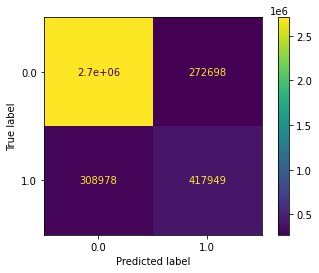

----------------------------------------------------------------------


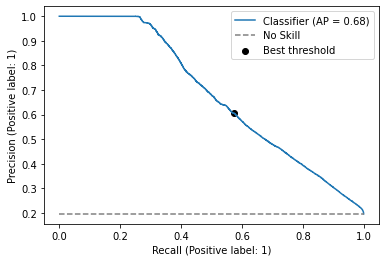

----------------------------------------------------------------------


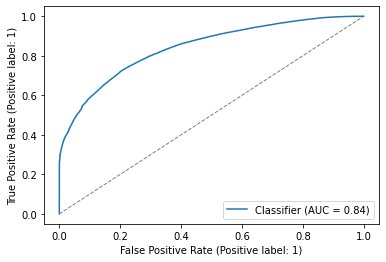

In [ ]:
# All scenarios - model allsc1
# metrics
from sklearn.preprocessing import MultiLabelBinarizer
os.chdir(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')
# modellstm = keras.models.load_model(veremiPath+t2Path+window+lstmPath+model+'/allscenarios1')
proba = modellstm.predict(data_test)
clTest = lb.inverse_transform(classes_test)
# Best threshold
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(clTest, proba[:, 1], pos_label=1)
# convert to f score
np.seterr(divide='ignore', invalid='ignore')
fscore = (2 * precision * recall) / (precision + recall)
np.nan_to_num(fscore, copy=False)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print("-"*70)
# Classification Report
from sklearn.metrics import classification_report
pred = np.where(np.array(proba[:, 1]) >= thresholds[ix], 1, 0)
print('Classification Report for md'+str(m)+'lstm'+'binary')
print(classification_report(clTest, pred, target_names=['class 0', 'class 1'], digits=3))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'binary'+'onlydist'+'.pdf')
plt.show()
print("-"*70)
# Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(clTest, proba[:, 1], pos_label=1)
# plt.title('PR curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
no_skill = len(clTest[clTest==1]) / len(clTest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', color="grey", label='No Skill')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best threshold')
plt.legend()
plt.savefig('PRcurve '+'md'+str(m)+'lstm'+'binary'+'onlydist'+'.pdf')
plt.show()
print("-"*70)
# ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(clTest, proba[:, 1], pos_label=1)
# plt.title('ROC curve '+'md'+str(m)+'w'+str(n)+'binary'+'.pdf')
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.savefig('ROCcurve '+'md'+str(m)+'lstm'+'binary'+'onlydist'+'.pdf')
plt.show()

In [ ]:
# ONLY DIST
# All scenarios 2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
# multi.iloc[:, -1].unique()
# retirar o RSSI
multionlydist = multi[['0', '2', '4', '6']]
# split data and label
data = multionlydist.iloc[:, 0:-1].values
classes = multionlydist.iloc[:, -1].values
# split data and label
data = multi.iloc[:, 0:-1].values
classes = multi.iloc[:, -1].values
# multilabel binarize
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.classes_
classes = lb.transform(classes)
# split test and train
data_train, data_test, classes_train, classes_test = train_test_split(data, classes, test_size=0.2, random_state=1)
data_train=data_train.reshape(data_train.shape[0], data_train.shape[1], 1)
data_test=data_test.reshape(data_test.shape[0], data_train.shape[1], 1)
print('data_train', data_train.shape)
print('data_test', data_test.shape)
print('classes_train', classes_train.shape)
print('classes_test', classes_test.shape)

data_train (14817733, 6, 1)
data_test (3704434, 6, 1)
classes_train (14817733, 6)
classes_test (3704434, 6)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
layer1 = keras.Input(shape=(data_train.shape[1], data_train.shape[2]))
layer2 = keras.layers.LSTM(lstmunits, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(lstmunits)(layer2)
output = keras.layers.Dense(classes_train.shape[1], activation="softmax")(layer3)
modelmulti = keras.Model(inputs=layer1, outputs=output, name='model'+str(m)+'multiclass')
print(modelmulti.summary())
# keras.utils.plot_model(model, "my_model.png", show_shapes=True)
modelmulti.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.Accuracy(),
             tf.keras.metrics.FalseNegatives()],
)
# all scenarios 2
start_time = time.time()
early_stopping = EarlyStopping(
    monitor="loss",
    patience=3,
    min_delta=1e-4,
    restore_best_weights=True
)
modelmulti.fit(
    data_train,
    classes_train,
    epochs=200,
    batch_size=1000,
    callbacks=[early_stopping]
)
print('Done in ', "{:.2f}".format(time.time() - start_time)+' sec', sep='')
# modellstm.save(veremiPath+t2Path+window+lstmPath+model+'/allscenarios2')

Model: "model1multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm_6 (LSTM)               (None, 6, 32)             4352      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 12,870
Trainable params: 12,870
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
14818/14818 [==============================] - 669s 45ms/step - loss: 0.5016 - accuracy: 0.0000e+00 - false_negatives_1: 2234189.0000
Epoch 2/200
14818/14818 [==

Classification Report for md1lstmmulti
              precision    recall  f1-score   support

     class 0      0.873     0.980     0.923   2977507
     class 1      0.703     0.618     0.658    144452
     class 2      0.000     0.000     0.000    143395
     class 4      0.991     0.990     0.991    145650
     class 8      0.601     0.172     0.268    145158
    class 16      0.441     0.148     0.222    148272

    accuracy                          0.863   3704434
   macro avg      0.602     0.485     0.510   3704434
weighted avg      0.809     0.863     0.826   3704434

----------------------------------------------------------------------


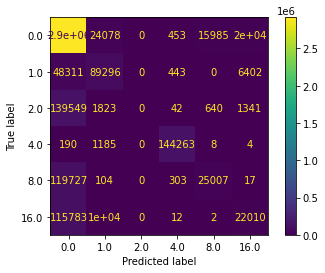

In [ ]:
# All scenarios - model allsc2
# metrics
os.chdir(veremiPath+t2Path+window+lstmPath+model+'/allscenarios2')
# Classification Report
from sklearn.metrics import classification_report
clTest = lb.inverse_transform(classes_test)
proba = modelmulti.predict(data_test)
pred = lb.inverse_transform(proba)
classlist = []
for cl in lb.classes_:
  classlist.append('class '+str(int(cl)))
print('Classification Report for md'+str(m)+'lstm'+'multi')
print(classification_report(clTest,
                            pred,
                            target_names=classlist,
                            digits=3,
                            zero_division=0))
print("-"*70)
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(clTest, pred, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)
disp.plot()
# plt.title('md'+str(m)+'w'+str(n)+'multi'+'.pdf')
plt.savefig('md'+str(m)+'lstm'+'multi'+'onlydist'+'.pdf')
plt.show()